In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from warnings import filterwarnings
filterwarnings('ignore')

## Importing Dataset

Orig_df = pd.read_csv('train.csv')
AV_test_df = pd.read_csv('test.csv')

## Data Analysis

Orig_df.shape

Orig_df.shape

### Data Check

Orig_df.head()

Orig_df.tail()

Orig_df.info()



### Descriptive Statistics

Orig_df.describe()

### Duplicate check

Orig_df.duplicated().any()



### Missing Value Check

Orig_df.isna().sum()



## Univariate Analysis

Orig_df.columns

Orig_df['ID'].nunique() 


to_drop = []
to_drop.append('ID')




Orig_df['Crop_Type'].value_counts()



Orig_df['Soil_Type'].value_counts()

Orig_df['Pesticide_Use_Category'].value_counts()

Orig_df['Number_Doses_Week'].value_counts()



Orig_df['Number_Weeks_Used'].value_counts()

# plt.bar(Orig_df['Number_Weeks_Used'],Orig_df['Number_Weeks_Used'].count())


Orig_df['Season'].value_counts()

Orig_df['Crop_Damage'].value_counts()

## Imputing the Missing Values

Orig_df['Number_Weeks_Used'] = Orig_df['Number_Weeks_Used'].fillna(Orig_df['Number_Doses_Week']) #imputed with the values of number of doses

AV_test_df.isna().sum()

AV_test_df['Number_Weeks_Used'] = AV_test_df['Number_Weeks_Used'].fillna(AV_test_df['Number_Doses_Week']) #imputed with the values of number of doses

Orig_df.isna().sum()

AV_test_df.isna().sum()

## Dropping columns

Orig_df.drop(columns=['ID'],inplace=True)

AV_test_df.drop(columns=['ID'],inplace=True)

## Creating X,y

X = Orig_df[['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season']]
y = Orig_df['Crop_Damage']

## Train Test Split

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,test_size=0.2)

## Scaling

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_scale = std_scaler.fit_transform(X_train)
X_test_scale = std_scaler.fit_transform(X_test)

## Applying models

print(X_train.shape,X_test.shape)

print(y_train.shape,y_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88858 entries, 0 to 88857
Data columns (total 10 columns):
ID                         88858 non-null object
Estimated_Insects_Count    88858 non-null int64
Crop_Type                  88858 non-null int64
Soil_Type                  88858 non-null int64
Pesticide_Use_Category     88858 non-null int64
Number_Doses_Week          88858 non-null int64
Number_Weeks_Used          79858 non-null float64
Number_Weeks_Quit          88858 non-null int64
Season                     88858 non-null int64
Crop_Damage                88858 non-null int64
dtypes: float64(1), int64(8), object(1)
memory usage: 6.8+ MB
(71086, 8) (17772, 8)
(71086,) (17772,)


(array([37743., 12024., 12779., 10665.,  7279.,  4350.,  2501.,  1041.,
          383.,    93.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <a list of 10 Patch objects>)

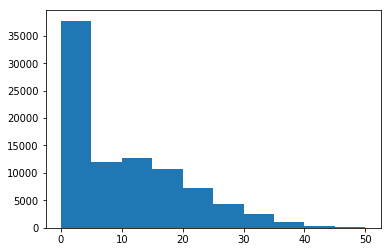

In [2]:
plt.hist(Orig_df['Number_Weeks_Quit'])

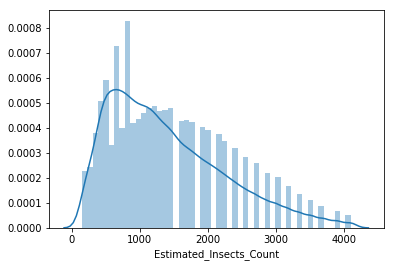

In [3]:
sns.distplot(Orig_df['Estimated_Insects_Count']) # its for Estimated insects count per square meter

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
params = {'n_estimators':[100,200,300,400],
                            'criterion':['gini','entropy'],
                            'max_depth':[2,3,4,5,7], 
                            'min_samples_split':[2,4,5], 
                            'min_samples_leaf':[2,4,6],
                            'max_leaf_nodes':[2,4,6,8]}

In [17]:
rf = RandomForestClassifier()
rscv = RandomizedSearchCV(rf,param_distributions=params,cv=5)

In [18]:
rscv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 7],
                                        'max_leaf_nodes': [2, 4, 6, 8],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [2, 4, 5],
                                        'n_estimators': [100, 200, 300, 400]})

In [19]:
rscv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=6,
                       min_samples_leaf=2, n_estimators=300)

In [21]:
rf_model = RandomForestClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=6,
                       min_samples_leaf=2, n_estimators=300,random_state=0)

In [22]:
rf_model.fit(X_train_scale,y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=6,
                       min_samples_leaf=2, n_estimators=300, random_state=0)

In [23]:
y_pred_rf = rf_model.predict(X_test_scale)

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
testing_score = round(accuracy_score(y_test,y_pred_rf),3)
training_score = round(np.mean((cross_val_score(rf_model, X_train_scale, y_train, cv=5))),3)


In [28]:
print(training_score,testing_score)

0.84 0.84


In [37]:
features = pd.Series(rf_model.feature_importances_,index=X_train.columns)
features.sort_values(ascending=False)

Number_Weeks_Used          0.244538
Pesticide_Use_Category     0.233311
Number_Weeks_Quit          0.231932
Estimated_Insects_Count    0.184171
Number_Doses_Week          0.088018
Crop_Type                  0.014513
Soil_Type                  0.003496
Season                     0.000022
dtype: float64

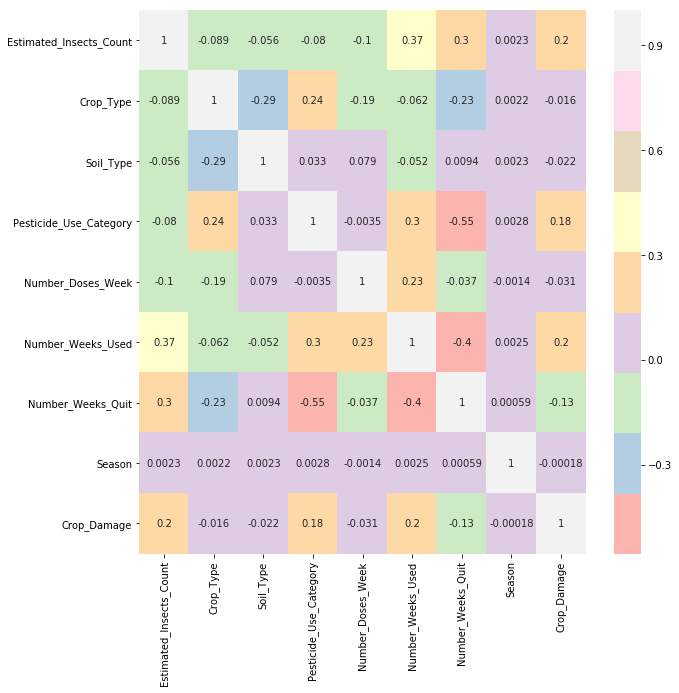

In [45]:
plt.figure(figsize=(10,10))
sns.heatmap(Orig_df.corr(),cmap='Pastel1',annot=True)

In [57]:
y_pred_res = rf_model.predict(AV_test_df)

In [61]:
AV_test_df = pd.read_csv('test.csv')
AV_test_df.shape

(59310, 9)

In [58]:
len(y_pred_res)

59310

In [63]:
result_out = AV_test_df[['ID']]
result_out['Crop_Damage'] = y_pred_res
result_out = result_out[['ID','Crop_Damage']]

In [64]:
result_out.to_csv('AV_Agri_RF.csv',index=False)

## Feature Engineering

In [67]:
Orig_df = pd.read_csv('train.csv')

In [68]:
Orig_df

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1
...,...,...,...,...,...,...,...,...,...,...
88853,F00155935,3337,1,0,2,10,12.0,44,3,0
88854,F00155938,3516,1,0,2,10,20.0,38,1,0
88855,F00155939,3516,1,0,2,15,40.0,8,2,0
88856,F00155942,3702,1,0,2,10,25.0,18,3,0


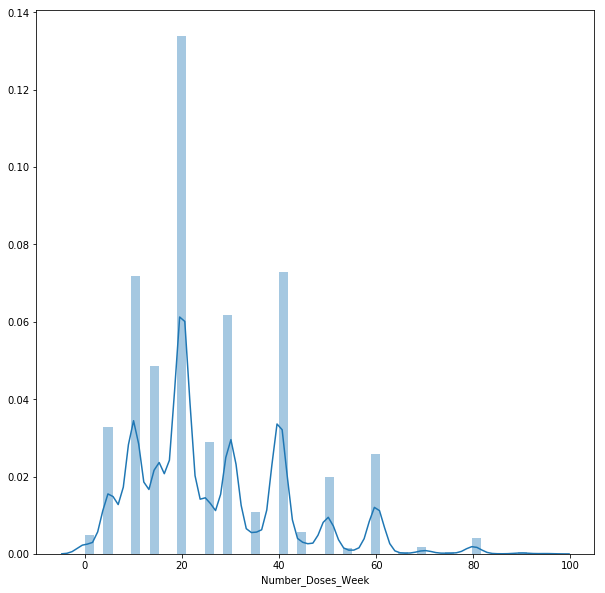

In [73]:
plt.figure(figsize=(10,10))
sns.distplot(Orig_df['Number_Doses_Week'])
#sns.distplot(Orig_df['Number_Weeks_Used'])
plt.show()

(array([ 1683.,  6627., 15249., 13610., 15155., 13487.,  6921.,  4991.,
         1850.,   285.]),
 array([ 0. ,  6.7, 13.4, 20.1, 26.8, 33.5, 40.2, 46.9, 53.6, 60.3, 67. ]),
 <a list of 10 Patch objects>)

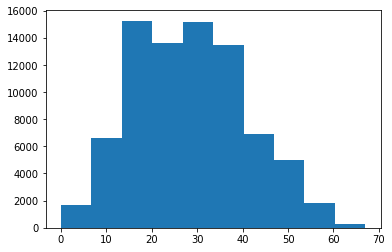

In [74]:
plt.hist(Orig_df['Number_Weeks_Used'])

In [75]:
Orig_df[Orig_df['Number_Weeks_Used'].isna()]

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
5,F00000008,448,0,1,1,0,NaN,0,2,1
6,F00000009,448,0,1,1,0,NaN,0,2,1
10,F00000021,1212,1,0,1,0,NaN,0,3,0
17,F00000037,2401,0,1,1,0,NaN,0,1,1
35,F00000076,257,0,0,3,30,NaN,0,2,0
...,...,...,...,...,...,...,...,...,...,...
88786,F00155793,1785,1,0,2,60,NaN,16,2,0
88788,F00155801,1898,1,0,2,15,NaN,3,1,0
88825,F00155882,2542,1,0,2,10,NaN,21,2,0
88833,F00155899,2687,1,0,2,10,NaN,21,2,0


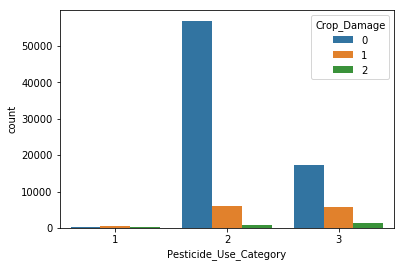

In [77]:
sns.countplot(Orig_df['Pesticide_Use_Category'],hue=Orig_df['Crop_Damage'])

In [87]:
Orig_df[(Orig_df['Pesticide_Use_Category']==3) & (Orig_df['Crop_Damage']==2)].count()

ID                         1469
Estimated_Insects_Count    1469
Crop_Type                  1469
Soil_Type                  1469
Pesticide_Use_Category     1469
Number_Doses_Week          1469
Number_Weeks_Used          1304
Number_Weeks_Quit          1469
Season                     1469
Crop_Damage                1469
dtype: int64